In [24]:
# import packages
import numpy as np
# import scipy.integrate as integrate
# from sympy import *
import time
import pickle

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

from matplotlib import cm
from matplotlib.ticker import LinearLocator
## set default plot size
plt.rcParams["figure.figsize"] = (10, 7)
## set global font size
plt.rcParams.update({'font.size':14})

# import astropy.units as u
from astropy import constants as const

from scipy.interpolate import interp1d


# Sampling Particle Trajectories

This notebook focuses on computing and animating the trajectories of individual particles within our two-hammer potential rather than the full solution $\delta f$. I will do this by using the analytical solution to Hamilton's equations, assuming two delta-function perturbations. (In `Leapfrogging Particle Trajectories.ipynb`, I will instead numerically solve Hamilton's equations, which won't necessarily assume delta-function perturbations.)

# Isothermal Slab Dynamics

First, we'll directly plot the motions of individual stars within a two-hammer, isothermal slab potential. The analytical (dimensionless) solutions to Hamilton's equations are:

$$ \theta(\tilde{t}) = \theta_0 + \int_0^{\tilde{t}} d\tilde{t}' \Omega(\tilde{J}(\tilde{t}')) $$
   $$ \tilde{J}(\tilde{t}) = \tilde{J}_0 + n_1 \tilde{A}_1 \sin(n_1\theta(\tilde{t}_1)) H(\tilde{t}-\tilde{t}_1) + n_2 \tilde{A}_2 \sin(n_2 \theta(\tilde{t}_2)) H(\tilde{t}-\tilde{t}_2) $$
   
where $\tilde{\Omega}$ is:

$$ \tilde{\Omega}(\tilde{J}) = \frac{1}{\sqrt{2}} \left[1+\frac{3\sqrt{2}}{\pi^2}\tilde{J}\right]^{-1/3}. $$

## Drawing from an arbitrary random distribution

Source: https://stackoverflow.com/a/64288861

In [2]:
def inverse_sample_decorator(dist):
    
    # for now, set our maximum J to 40
    def wrapper(pnts, x_min=0, x_max=40, n=1e5, **kwargs):
        
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        cumulative -= cumulative.min()
        f = interp1d(cumulative/cumulative.max(), x)
        return f(np.random.random(pnts))
    
    return wrapper

# example distribution
# @inverse_sample_decorator
# def gauss(x, amp=1.0, mean=0.0, std=0.2):
#     return amp*np.exp(-(x-mean)**2/std**2/2.0)

In [3]:
## define the slab Omega, Hamiltonian, and f0(J)

def compute_Omega(J):
    '''
    Represents (dimensionless) Omega(J). We use Omega = a/(1 + b*J)^(1/3)
    
    '''
    
    a = 1. / np.sqrt(2)
    b = 3 * np.sqrt(2) / pow(np.pi,2)

    return a * pow(1 + b*J, -1/3)

def Hamiltonian(J):
    '''
    Computes the Hamiltonian of our system by integrating Omega(J)
    from 0 to J. (Underneath Eq. 8 in Scott's paper, it's stated that
    Omega = dH/dJ.) We assume that Omega=0 for H=0.
    
    We use Omega = a/(1 + b*J)^(1/3) and its analytical antiderivative.
    
    '''
    
    term1 = np.pi**2 / 4
    b = 3*np.sqrt(2) / (np.pi**2)
    
    term2 = (1 + b*J)**(2/3)
    return term1 * term2


def f_0(J): 
    '''
    Initial distribution function of our system, using Eq. 6 of Scott's
    paper.
    
    '''
    
    return np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)

@inverse_sample_decorator
def f_0_distro(J): 
    '''
    The version of f_0(J) we use to perform inverse transform sampling.
    
    '''
    
    return np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)

In [ ]:
# np.random.seed(2)

# # generate a list of 100 random J values
# N = 10000
# num_iterations = 10
# Js_temp = np.zeros((N))
# for i in range(num_iterations):
#     Js_temp += np.sort(f_0_distro(N))

# Js_temp = Js_temp / num_iterations
# print(Js_temp[-10:])

## Outline

Let N be the number of particles I'm simulating. (I should test N=1, 10, 100, ...). Our plan is:

1. Keep two N-length arrays, one representing the $\theta$'s of all the particles and one representing all the $J$'s at a certain timepoint $t_i$.
2. Keep an array with timepoints, e.g., `ts = np.arange(0, 300, 0.5)`.
3. Set the initial conditions. Each $J_0$ should be in $(0, 20)$, while each $\theta_0$ should be in $[0, 2\pi)$.
4. Update $\theta$ at every timestep. Update $J$ and $\Omega(J)$ iff there's a hammer.

## convert from $(\theta, J)$ to $(z,v_z)$

In [4]:
## functions for converting (thetas, Js) to (zs, vzs)

def pol2cart_harmonic(thetas, Js):
    '''
    Given a set of angles and actions (thetas, Js), return the 
    corresponding Cartesian coordinates assuming a harmonic potential.
    
    '''
    
    zs = np.sqrt(Js) * np.sin(thetas)
    vzs = np.sqrt(Js) * np.cos(thetas)
    
    return zs, vzs

## load in interpolated converter functions
# AA -> CC
with open('z(theta,J)_interp.pkl', 'rb') as file:
    convert_AA_to_z = pickle.load(file)
with open('v_z(theta,J)_interp.pkl', 'rb') as file:
    convert_AA_to_vz = pickle.load(file)
# CC -> AA
with open('theta(z,v_z)_interp.pkl', 'rb') as file:
    convert_CC_to_theta = pickle.load(file)
with open('J(z,v_z)_interp.pkl', 'rb') as file:
    convert_CC_to_J = pickle.load(file)

def pol2cart_exact(thetas, Js):
    '''
    Given a set of angles and actions (thetas, Js), return the 
    exact (zs, v_zs) coordinates.
    
    '''
    
    zs = convert_AA_to_z(thetas, Js)
    v_zs = convert_AA_to_vz(thetas, Js)
    
    return zs, v_zs

In [25]:
## define hammer params, phase space range

# define the parameters of the two hammers (t_i, n_i, A_i)
t1, t2 = 0, 100
n1, n2 = 1, 3
A1, A2 = 0.1, 0.2

# define ts, thetas, and Js; and, corresponding Cartesian coords
N = (int) (1e5) # number of particles

# time range
tmin = 0
tmax = 200
tstep = 0.5
ts = np.arange(tmin, tmax+tstep, tstep)

# Monte Carlo sample our initial conditions
np.random.seed(2)
thetas = (2*np.pi) *np.random.rand(N)
Js = f_0_distro(N) # drawn from f_0(J)

# initial Omega values
Omegas = compute_Omega(Js)

# initial z, v_z values
use_exact_conversion = True

if use_exact_conversion:
    zs, vzs = pol2cart_exact(thetas, Js)  
else:
    zs, vzs = pol2cart_harmonic(thetas, Js)  

In [ ]:
# ## check that sampling method is consistent with underlying distro

# Js_temp = np.arange(0, 20, 1e-2)

# # sampled J's
# num_bins = 20
# bins = np.linspace(0, np.max(Js), num=num_bins)
# hist = plt.hist(Js, bins=bins, label="sampled data", density=True)

# ## distribution function
# J_axis = (hist[1][:-1] + hist[1][1:]) / 2 # midpoints of histogram bins
# f0_temp = f_0(J_axis)

# plt.plot(J_axis, f0_temp / .056, label="$f_0(J)$")

# plt.title("Comparison of sampled J's to f_0(J)")
# plt.legend()
# plt.show()

# Plot $f$ right before hammer 1 $(t=0^-)$

In [ ]:
# ~97% of the particles exist at J<7 orbits
np.sum(Js < 7) / N

To calculate $\delta n / n_0$ at a certain position ($z=z'$), we'll define the quantity $n(t)$ as the spatial density at that point. Here, we approximate $n(t)$ as the number of particles in a certain z bin divided by the width of the bin. By definition, $n(0) = n_0$, i.e., the background or equilibrium value.

Therefore:

$$\frac{\delta n}{n_0} \Big|_{z=z'} = \frac{n(t) - n(0^-)}{n(0)}\Big|_{z=z'}.$$

n_0 = 1474


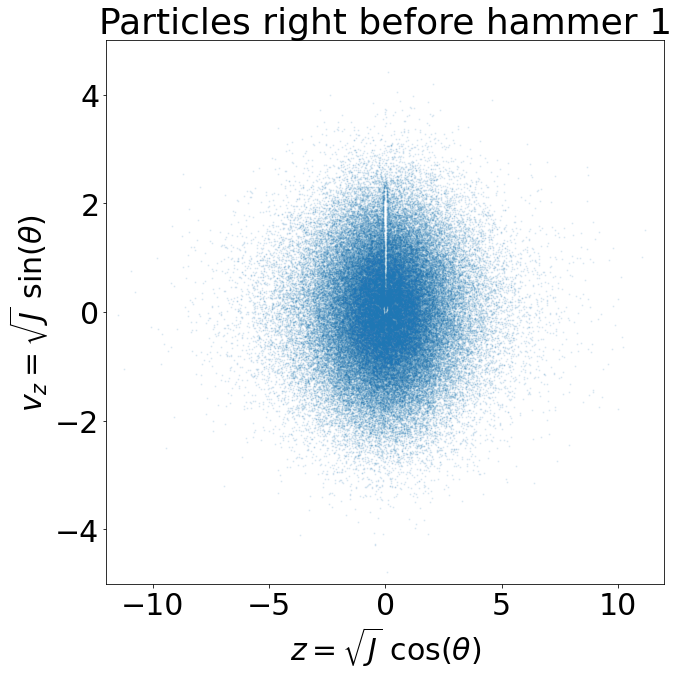

In [26]:
# calculate n_0 and plot initial condition
plt.rcParams.update({'font.size':30})

z_tolerance = 5e-2
plot_initial_distro = True

fig = plt.figure(figsize=(10,10))

# number of particles at t=0 within z_tolerance at a z coordinate; this is the
# "background" distribution
z_offset = 1.5
n_0 = np.sum(np.abs(zs - z_offset) < z_tolerance) 
print(f'n_0 = {n_0}')
n_0 /= len(zs) # normalize by # of particles

if plot_initial_distro:
    xlimit = 12
    ylimit = 5
    plt.xlim(-xlimit, xlimit)
    plt.ylim(-ylimit, ylimit)

    scat = plt.scatter(zs, vzs, s=1, alpha=0.1) # particles don't appear at alpha~0.001
    
    plt.xlabel(r"$z = \sqrt{J}$ cos($\theta$)")
    plt.ylabel(r"$v_z = \sqrt{J}$ sin($\theta$)")

    plt.title('Particles right before hammer 1')

    plt.show()

# Animation

In [21]:
thetas_temp = np.linspace(0, 2*np.pi, 1000)
np.max(np.abs(convert_AA_to_z(thetas_temp, 0.7)))

1.44236784087872

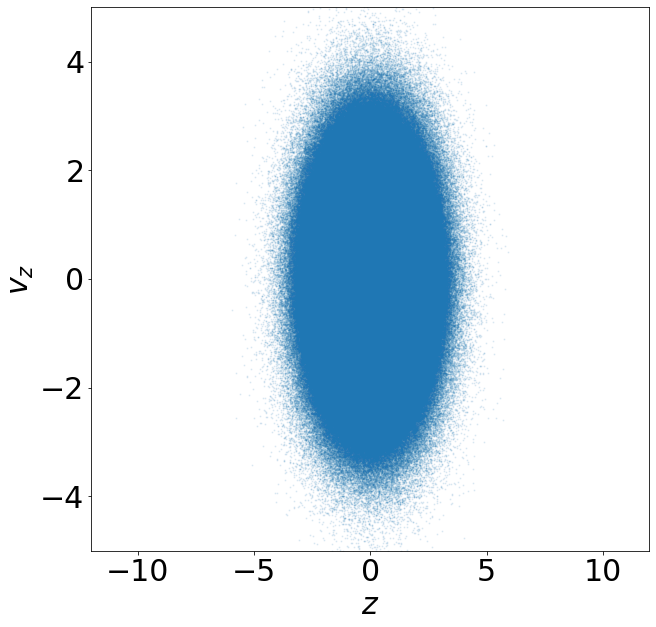

In [28]:
# make the animation
plt.rcParams.update({'font.size':30})

fig = plt.figure(figsize=(10,10))
scat = plt.scatter(zs, vzs, s=1, alpha=0.1)

xlimit = 12
ylimit = 5
plt.xlim(-xlimit, xlimit)
plt.ylim(-ylimit, ylimit)

# plt.xlabel(r"$z = \sqrt{J}$ cos($\theta$)")
# plt.ylabel(r"$v_z = \sqrt{J}$ sin($\theta$)")
plt.xlabel(r"$z$")
plt.ylabel(r"$v_z$")

# the "density" at z=0 (in practice, the number of points near z=0) as a function of time
delta_n_over_ns = []
ns = []

# snapshots at which we'll save the figure
ts_for_savefig = [0.0, 99.5, 100, 125, 150, 200]

start = time.time()

# simulating pointers with a dictionary... not ideal but we'll see if it works
# source: https://realpython.com/pointers-in-python/#using-python-objects
# WARNING: editing these variables' contents also edits the contents of thetas, Js
variables = {"hammer1_has_hit": False, "hammer2_has_hit": False, \
             "thetas": thetas, "Js": Js, "Omegas": Omegas}

def updatefig(i):
    t = ts[i]
    
    if ((t % 10) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')

    # update Js, Omegas iff there's a hammer
    hammers_on = True
    if hammers_on:
        if ((not variables["hammer1_has_hit"]) and (t >= t1)):
            variables["Js"] += n1 * A1 * np.sin(n1 * variables["thetas"])
            variables["Omegas"] = compute_Omega(variables["Js"])
            variables["hammer1_has_hit"] = True

        if ((not variables["hammer2_has_hit"]) and (t >= t2)):
            variables["Js"] += n2 * A2 * np.sin(n2 * variables["thetas"])
            variables["Omegas"] = compute_Omega(variables["Js"])
            variables["hammer2_has_hit"] = True

    # update thetas
    variables["thetas"] += variables["Omegas"] * tstep
    variables["thetas"] = np.mod(variables["thetas"], 2*np.pi)
    
    J_is_negative = (variables["Js"] < 0)
    
    ## move negative-J particles to J~0 orbits
    move_negative_J_particles = True
    if move_negative_J_particles:
        variables["Js"][J_is_negative] = 0
    
    ## convert coordinates to (z, v_z)
    if use_exact_conversion:
        zs, vzs = pol2cart_exact(variables["thetas"], 
                           variables["Js"])
    else:
        zs, vzs = pol2cart_harmonic(variables["thetas"], 
                           variables["Js"])
    
    ## compute delta n / n_0, ie, number density contrast
    
    # number of particles at t=0 within z_tolerance of our selected z coordinate
    n_t = np.sum(np.abs(zs - z_offset) < z_tolerance) / len(zs)
    delta_n_over_n = (n_t - n_0) / n_0
    delta_n_over_ns.append(delta_n_over_n)
    ns.append(n_t)
    
    # make plot
    data = np.transpose((zs, vzs))
    scat.set_offsets(data)
    plt.legend(title=f"t={t}", loc='upper left', labelspacing=0.)
    #plt.title('Particle trajectories (t=' + str(t) + ')')

    save_fig = False
    if save_fig and make_animation:
    # save figure at certain snapshots
        if t in ts_for_savefig:
            plt.savefig(f'Sampling trajectories (thesis)/Sampled_trajs_t={t}.png')
    
    return scat,

make_animation = False
if make_animation:
    ani = animation.FuncAnimation(fig, updatefig, interval=100, frames=len(ts), \
            blit=True)
    ani.save("Sampled_trajectories_temp.mp4")

In [23]:
# number of stars that get pushed to J=0
np.sum(variables["Js"] == 0)

10265

Source on animating a scatter plot: https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot

# density plot

In [27]:
## define hammer params, phase space range

# define the parameters of the two hammers (t_i, n_i, A_i)
t1, t2 = 0, 100
n1, n2 = 1, 3
A1, A2 = 0.1, 0.2

# define ts, thetas, and Js; and, corresponding Cartesian coords
N = (int) (1e7) # number of particles

# time range
tmin = 0
tmax = 300
tstep = 0.5
ts = np.arange(tmin, tmax+tstep, tstep)

# Monte Carlo sample our initial conditions
np.random.seed(2)
thetas = (2*np.pi) *np.random.rand(N)
Js = f_0_distro(N) # drawn from f_0(J)

# initial Omega values
Omegas = compute_Omega(Js)

# initial z, v_z values
use_exact_conversion = False
if use_exact_conversion:
    zs, vzs = pol2cart_exact(thetas, Js)  
else:
    zs, vzs = pol2cart_harmonic(thetas, Js)  

In [ ]:
# calculate delta_n_over_ns array, avoiding the animation
start = time.time()
delta_n_over_ns = []
ns = []

# simulating pointers with a dictionary... not ideal but we'll see if it works
# source: https://realpython.com/pointers-in-python/#using-python-objects
# WARNING: editing these variables' contents also edits the contents of thetas, Js
variables = {"hammer1_has_hit": False, "hammer2_has_hit": False, \
             "thetas": thetas, "Js": Js, "Omegas": Omegas}

for i in range(len(ts)):
    updatefig(i)

t = 0.0
Elapsed t: 0.0 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 10.0
Elapsed t: 18.3 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 20.0
Elapsed t: 35.7 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 30.0
Elapsed t: 52.5 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 40.0
Elapsed t: 69.6 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 50.0
Elapsed t: 86.6 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 60.0
Elapsed t: 103.1 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 70.0
Elapsed t: 120.1 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 80.0
Elapsed t: 137.0 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 90.0
Elapsed t: 153.9 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 100.0
Elapsed t: 171.1 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 110.0
Elapsed t: 188.8 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 120.0
Elapsed t: 204.7 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 130.0
Elapsed t: 220.8 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 140.0
Elapsed t: 236.7 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 150.0
Elapsed t: 252.8 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 160.0
Elapsed t: 271.2 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 170.0
Elapsed t: 289.1 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


t = 180.0
Elapsed t: 307.8 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [ ]:
fig = plt.figure(figsize=(16,8))

plt.plot(ts, delta_n_over_ns)

plt.xlabel('t')
plt.ylabel('$\delta n/n_0$')
#plt.title(f'Density contrast at z={z_offset}, z_tolerance={z_tolerance}')

save_fig = True
if save_fig:
    plt.savefig(f'sampling_deltan_N={N:.1E}_z={z_offset}.png',dpi=300)
plt.show()